# Data Analysis
This notebook is used to analyze the data collected from live runs. It includes various visualizations and statistical analyses to understand the performance of the runner

## TOC:
### [Feature Engineering](#tests-for-feature-engineering)
### [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
* [Performance from Specific Runs](#performance-from-specific-runs)
* [Pearsons Correlation Matrix for Specific Runs](#pearsons-correlation-matrix-for-specific-runs)
* [Variance Inflation Factor (VIF)](#variance-inflation-factor-vif)
* [Rolling Windowed Correlation](#rolling-windowed-correlation)
* [Multivariate Regression](#multivariate-regression)

In [1]:
from utilis.helper import *
import matplotlib.pyplot as plt
import pandas as pd
output_folder = extract_global_json("output_folder")


# Tests for Feature Engineering
This section is just a placeholder for testing feature engineering techniques. It will include various tests and experiments to improve the data quality and feature set.

In [2]:
# import output folder
import os
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt

# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Optional: widen the display to avoid line wrapping
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)  # or a large int, e.g. 200


def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates custom bearing where:
    0° = South, 90° = West, 180° = North, 270° = East
    """

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    delta_lon = lon2 - lon1

    x = math.sin(delta_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - \
        math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)

    standard_bearing = math.atan2(x, y)
    standard_bearing_deg = (math.degrees(standard_bearing) + 360) % 360  # 0° = North

    # # Rotate so 0° = South, 90° = West
    # custom_bearing = (standard_bearing_deg + 180) % 360

    return standard_bearing_deg  # Return the standard bearing in degrees

output_folder = extract_global_json("output_folder")

# folder = "2025-07-05_12-32"
# folder = "2025-07-22_19-40"
# folder = "2025-07-25_19-53"
# folder = "2025-07-27_10-27"
# folder = "2025-07-29_20-03"
# folder = "2025-07-31_20-07"
folder = "2025-08-02_18-02"
# folder = "2025-08-04_20-02"
# loop through all folders in the output folder
for folder_name in os.listdir(output_folder):
    if folder in folder_name:
        # first read the csv file
        csv_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_streams.csv")
        json_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_overall.json")

        break
#         data = pd.read_csv(csv_file_path)

# # get the csv file path and json file path
# json_file_path = os.path.join(output_folder, folder, f"{folder}_overall.json")
# csv_file_path = os.path.join(output_folder, folder, f"{folder}_streams.csv")

# read the csv file
data = pd.read_csv(csv_file_path)
overall_data = extract_json(json_file_path)

# --------------------------- WIND DIRECTION AND SPEED ---------------------------
# determine direction in which person is currently moving
# create a new column for the bearing
# first row will have no bearing, so we will calculate the bearing for the first two rows
data["delta_latitude"] = data["latitude"].diff()
data["delta_longitude"] = data["longitude"].diff()
for i in range(1, len(data)):
    lat1, lon1 = data.loc[i - 1, ["latitude", "longitude"]]
    lat2, lon2 = data.loc[i, ["latitude", "longitude"]]
    data.at[i, "athletedir_degree"] = calculate_bearing(lat1, lon1, lat2, lon2)

# add wind direction and speed to the data
data["winddir_degree"] = extract_json(json_file_path)["weather"]["winddir"]  # Wind direction in degrees
data["windspeed_mps"] = extract_json(json_file_path)["weather"]["windspeed"]*1000/3600  # Convert from km/h to m/s

# calculate the relative wind direction
data["relative_winddir_degree"] = (data["winddir_degree"] - data["athletedir_degree"]) % 360
data["headwind_mps"] = data["windspeed_mps"] * np.cos(np.radians(data["relative_winddir_degree"]))
data["crosswind_mps"] = data["windspeed_mps"] * np.sin(np.radians(data["relative_winddir_degree"]))
data["headwind_mps"] = data["headwind_mps"].fillna(0)  # Fill NaN values with 0
data["crosswind_mps"] = data["crosswind_mps"].fillna(0)  # Fill NaN values with 0

# --------------------------- STRIDE LENGTH ---------------------------
data["stride_length_m"] = data["velocity_mps"] / (data["cadence_rpm"] / 60)  # meters per stride
data["stride_length_m"] = data["stride_length_m"].fillna(0)  # Fill NaN values with 0
# set stride length to 0 if it is infinity
data.loc[data["stride_length_m"] == np.inf, "stride_length_m"] = 0  # Set infinity to 0

# --------------------------- ALTITUDE CHANGE ---------------------------
data["altitude_change_m"] = data["altitude_m"].diff().fillna(0)  # Change in altitude

# --------------------------- PACE EFFICIENCY ---------------------------
# data["pace_efficiency"] = data["velocity_mps"] / (data["heartrate_bpm"] / 60)  # m/s per bpm
# resting heart rate
resting_heart_rate = 60  # bpm
data["pace_efficiency"] = (data["velocity_mps"] / overall_data["max_speed"]) * (1 - (data["heartrate_bpm"] - resting_heart_rate) / overall_data["max_heartrate"])

# filter out data where moving is False
data = data[data["moving"] == True]

# data

# Exploratory Data Analysis (EDA)
This section will include various exploratory data analysis techniques to understand the data better, including visualizations and statistical summaries.

### Performance from Specific Runs
This section will focus on analyzing the performance from specific runs, including visualizations and statistical summaries.

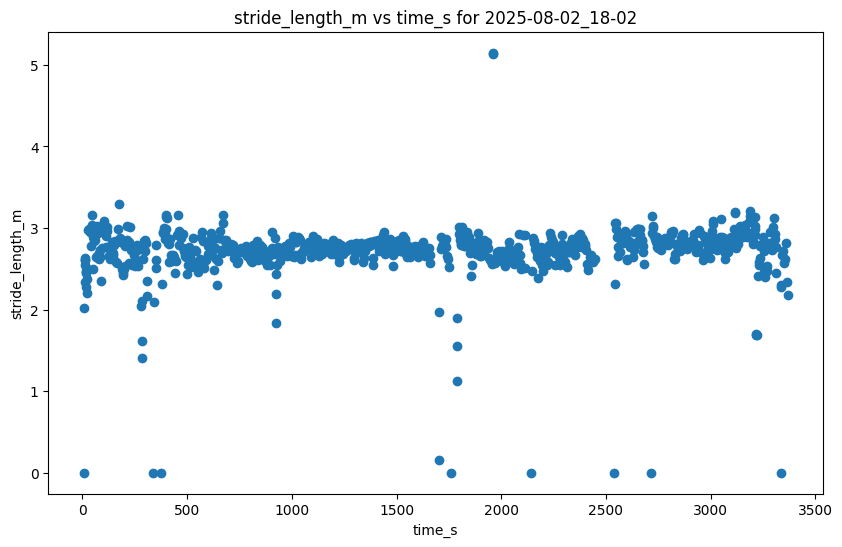

In [3]:
# x = "altitude_m"
# x = "altitude_change_m"
# y = "pace_efficiency"
y = "stride_length_m"
# y = "heartrate_bpm"

# x = "cadence_rpm"
# x = "grade_percent"
x = "time_s"
# y = "altitude_m"
# y = "cadence_rpm"

# x_list = []
# y_list = []

# get the time and cadence columns
x_data = data[x]
y_data = data[y]

# plot this data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label=folder_name)
# plt.plot(x_data, y_data, label=folder_name)
plt.xlabel(x)
plt.ylabel(y)
plt.title(f"{y} vs {x} for {folder_name}")
plt.show()





### Pearsons Correlation Matrix for Specific Runs

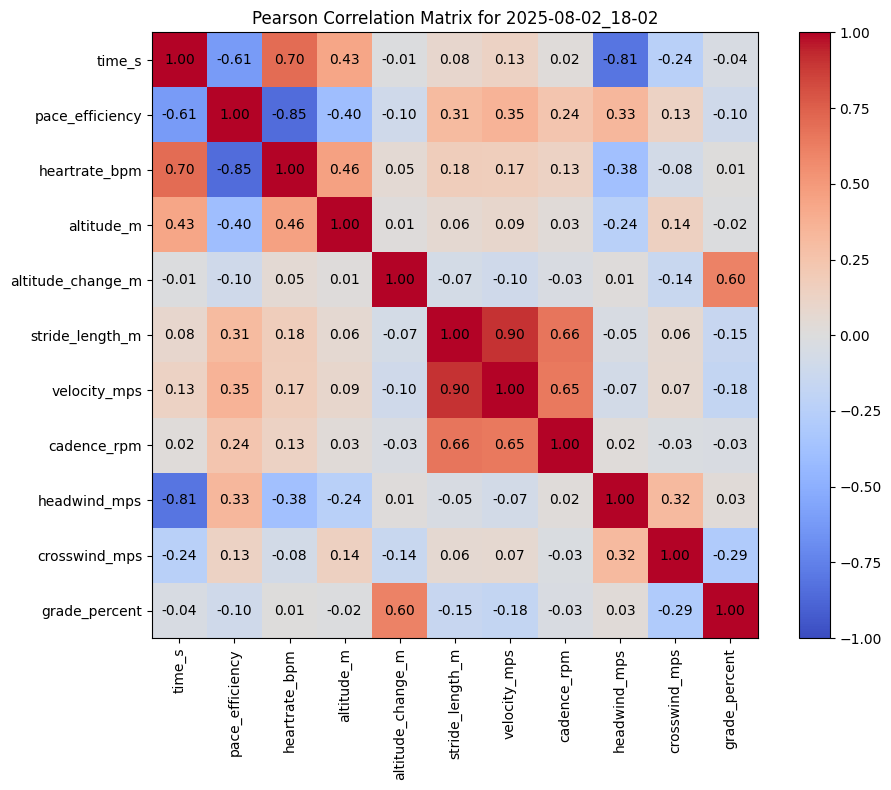

In [4]:


# Exploratory Data Analysis (EDA)
analyzable_columns = [
    "time_s",
    "pace_efficiency",
    "heartrate_bpm",
    "altitude_m",
    "altitude_change_m",
    "stride_length_m", 
    "velocity_mps", 
    "cadence_rpm", 
    "headwind_mps", 
    "crosswind_mps", 
    # "athletedir_degree", 
    # "relative_winddir_degree", 
    "grade_percent"
]
corr_matrix = data[analyzable_columns].corr()

# Show correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
for i in range(len(analyzable_columns)):
    for j in range(len(analyzable_columns)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")
plt.colorbar()
# plt.xticks(range(len(analyzable_columns)), analyzable_columns, rotation=30)
plt.xticks(range(len(analyzable_columns)), analyzable_columns, rotation=90)
plt.yticks(range(len(analyzable_columns)), analyzable_columns)
plt.title(f"Pearson Correlation Matrix for {folder_name}")
plt.tight_layout()
plt.show()
# data

### Variance Inflation Factor (VIF)
This section will calculate the Variance Inflation Factor (VIF) for the features in the dataset to check for multicollinearity.

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from statsmodels.api import add_constant

# only look at numerical columns for VIF
data_numerical = data.select_dtypes(include=[float, int])

# Assuming X is your design matrix with a constant added
X = add_constant(data_numerical)  # df = your feature DataFrame
# X = add_constant(data_numerical.drop(columns=["pace_efficiency"]))  # df = your feature DataFrame
vif = pd.DataFrame()
vif["feature"] = X.columns
# data_numerical
vif["VIF"] = [int(variance_inflation_factor(X.values, i)) for i in range(X.shape[1])]
print(vif)

                    feature   VIF
0                    time_s  3237
1             heartrate_bpm    49
2               cadence_rpm     2
3                distance_m  3171
4                altitude_m     2
5              velocity_mps    17
6             grade_percent     2
7                  latitude    53
8                 longitude    50
9            delta_latitude     9
10          delta_longitude     9
11        athletedir_degree     9
12           winddir_degree     0
13            windspeed_mps     0
14  relative_winddir_degree     3
15             headwind_mps    15
16            crosswind_mps     7
17          stride_length_m     5
18        altitude_change_m     1
19          pace_efficiency    55


c:\Users\katzr\Desktop\University\Projects\Marathon_Simulation\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


### Rolling Windowed Correlation

<Axes: title={'center': 'Rolling Correlation: Heart Rate vs Headwind'}, xlabel='Time Steps', ylabel='Correlation Coefficient'>

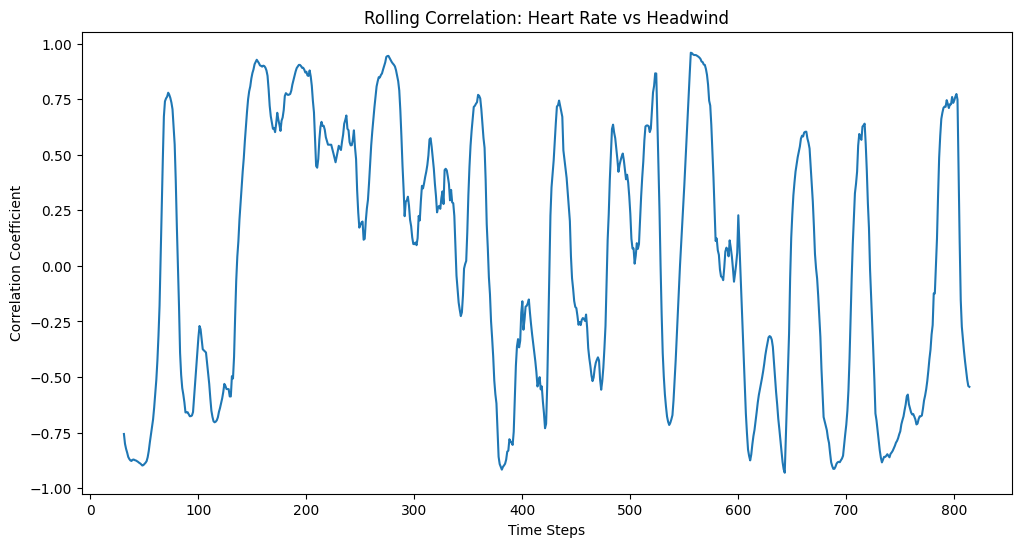

In [6]:
# Assuming df has columns 'heart_rate' and 'headwind'
window_size = 30  # e.g., 60 time steps
# rolling_corr = data['heartrate_bpm'].rolling(window=window_size).corr(data['distance_m'])
# rolling_corr = data['heartrate_bpm'].rolling(window=window_size).corr(data['headwind_mps'])
# rolling_corr = data['heartrate_bpm'].rolling(window=window_size).corr(data['time_s'])
rolling_corr = data['heartrate_bpm'].rolling(window=window_size).corr(data['altitude_m'])
rolling_corr.plot(title="Rolling Correlation: Heart Rate vs Headwind", figsize=(12, 6), ylabel='Correlation Coefficient', xlabel='Time Steps')

### Multivariate Regression
This section will include multivariate regression analysis to understand the relationships between different features and the target variable

In [36]:
from statsmodels.api import OLS, add_constant

analyzable_columns = [
    # "time_s",
    "distance_m",
    # "heartrate_bpm",
    # "altitude_m",
    "altitude_change_m",
    # "stride_length_m", 
    # "velocity_mps", 
    # "cadence_rpm", 
    "headwind_mps", 
    "crosswind_mps", 
    # "athletedir_degree", 
    # "relative_winddir_degree", 
    "grade_percent"
]

# test exponential regression

# x = data["grade_percent"]
x = data[analyzable_columns]
y = data['pace_efficiency']
# y = data['pace_efficiency'].tolist()
X = add_constant(x)

model = OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        pace_efficiency   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     143.5
Date:                Wed, 06 Aug 2025   Prob (F-statistic):          3.55e-108
Time:                        15:32:54   Log-Likelihood:                 1033.0
No. Observations:                 793   AIC:                            -2054.
Df Residuals:                     787   BIC:                            -2026.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5125      0.00

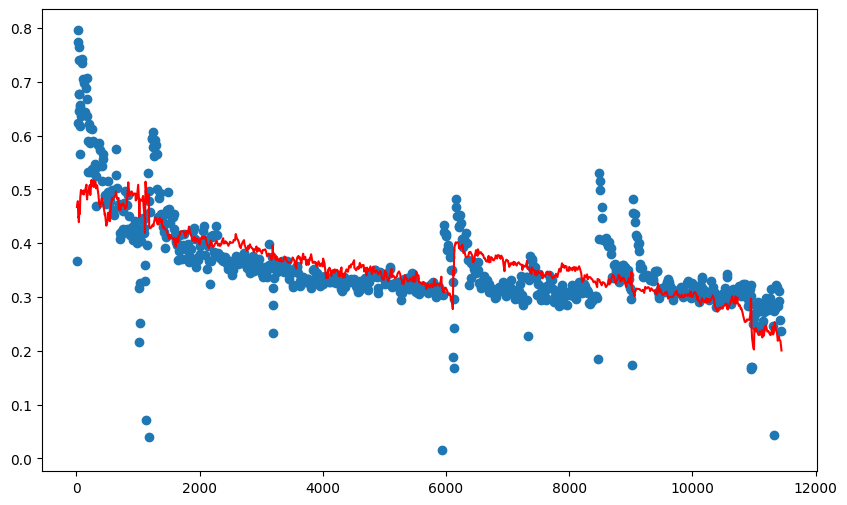

In [37]:
# predict pace efficiency based on the model
y_pred = model.predict(X)
# # Plot the data and the fitted line
plt.figure(figsize=(10, 6))
plt.scatter(data["distance_m"], y, label='Data Points')
plt.plot(data["distance_m"], y_pred, color='red', label='Fitted Line')